# Preperations


## Imports


In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import numpy as np
from src.consts import PATHS

## Constants

In [2]:
base_output_dir = PATHS.PROJECT_DIR / 'output'

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

## Loading Data

### Load Known Files Pre-processed Evaluations
#

In [69]:
known_1000_correct_files_raw = {
    tuple(experiment_path.name.replace('minimal_', '').rsplit("_", maxsplit=1)): pd.read_csv(known_1000_correct_file)
    for experiment_path in base_output_dir.iterdir()
    if (
        known_1000_correct_file := experiment_path
        / "evaluate"
        / "known_1000_correct.csv"
    ).exists()
}

### Preprocess Data

In [70]:
def remove_generation_prefix(df):
    # For some models, the generation is prefixed with the prompt
    return df.apply(
        lambda x: x["model_generation"].removeprefix(
            x["prompt"],
        ),
        axis=1,
    )


def is_correct(target, prediction) -> bool:
    return len(target) > 0 and target.startswith(prediction.strip())


def fix_model_correct(df):
    # Make sure that model_output is at least 1 character long; if empty, it's incorrect
    return df.apply(
        lambda x: is_correct(x["attribute"], x["model_output"]),
        axis=1,
    )


def split_top_outputs(df):
    df = df.copy()
    COL = "model_top_outputs"
    for i in range(len(df[COL].iloc[0])):
        df[f"pred_{i+1}"] = (
            df[COL].apply(lambda x: [item[0] for item in x]).apply(lambda x: x[i])
        )
        df[f"confidence_{i+1}"] = (
            df[COL].apply(lambda x: [item[1] for item in x]).apply(lambda x: x[i])
        )

    return df.drop(columns=COL)


def correct_output_position(df):
    preds = df.pipe(split_top_outputs)
    preds["correct_position"] = np.inf
    for i in range(1, 6):
        preds["correct_position"] = preds.apply(
            lambda x: (
                min(x["correct_position"], i)
                if is_correct(x["attribute"], x[f"pred_{i}"])
                else x["correct_position"]
            ),
            axis=1,
        )
    return preds["correct_position"]

def confidence_diff(df):
    preds = df.pipe(split_top_outputs)

    return preds.apply(
        lambda x: np.inf if x["correct_position"] == np.inf else x[f"confidence_1"] - x[f"confidence_{int(x['correct_position'])}"],
        axis=1,
    )
    
known_1000_correct_files = {
    experiment_name: (
        df.assign(
            **{
                "model_output": lambda df: df["model_output"].fillna(""),
                "model_top_outputs": lambda df: df["model_top_outputs"].apply(ast.literal_eval),
            }
        ).assign(
            **{
                "model_generation": remove_generation_prefix,
                "model_correct": fix_model_correct,
                "correct_position": correct_output_position,
                'confidence_diff': confidence_diff,
            }
        )
        .assign(
            **{
                "any_correct": lambda df: df["correct_position"] != np.inf,
            }
        )
    )
    for experiment_name, df in sorted(known_1000_correct_files_raw.items())
}

In [71]:
# Show keys of the files
print(known_1000_correct_files[next(iter(known_1000_correct_files))].keys())

print(known_1000_correct_files.keys())

Index(['known_id', 'subject', 'attribute', 'template', 'prediction', 'prompt',
       'relation_id', 'model_correct', 'model_top_output_confidence',
       'model_top_outputs', 'model_generation', 'model_output',
       'correct_position', 'confidence_diff', 'any_correct'],
      dtype='object')
dict_keys([('llama2', '7b'), ('llama3.2', '1B'), ('llama3.2', '3B'), ('mamba1', '130M'), ('mamba1', '2.8B'), ('mamba2', '130M'), ('mamba2', '2.7B')])


In [203]:
# Sort known_1000_correct_files by experiment name
per_model_stats_dict = []

# Print experiment details in a hierarchical format
current_arch = None
for (arch_name, size), df in known_1000_correct_files.items():
    df_correct = df[df["any_correct"]]
    position_value_counts = df_correct["correct_position"].value_counts() / len(df)
    per_model_stats_dict.append({
        "arch_name": arch_name,
        "size": size,
        "accuracy": f"{df['model_correct'].mean():.2%}",
        "accuracy_any_correct": f"{df['any_correct'].mean():.2%}",
        'mean_confidence_diff': f"{df_correct['confidence_diff'].mean(): .2e}",
        'mean_correct_position': f"{df_correct['correct_position'].mean():.2f}",
        'mean_correct_top_output_confidence': f"{df_correct['model_top_output_confidence'].mean():.2f}",
        ** {
            f"correct_position_{int(position)}": f"{count:.2%}" 
            for position, count in position_value_counts.items()
        }
    })
    
per_model_stats_df = (
    pd.DataFrame(per_model_stats_dict)
)
per_model_stats_df

,arch_name,size,accuracy,accuracy_any_correct,mean_confidence_diff,mean_correct_position,mean_correct_top_output_confidence,correct_position_1,correct_position_2,correct_position_3,correct_position_4,correct_position_5
0,llama2,7b,75.77%,94.13%,2.82e-02,1.34,0.51,75.85%,9.59%,4.71%,2.65%,1.32%
1,llama3.2,1B,73.95%,95.45%,2.59e-02,1.38,0.42,73.95%,11.75%,6.04%,2.07%,1.65%
2,llama3.2,3B,74.61%,94.54%,2.70e-02,1.37,0.49,74.61%,11.33%,3.89%,3.23%,1.49%
3,mamba1,130M,40.28%,75.27%,4.01e-02,1.91,0.19,40.28%,15.22%,10.01%,5.79%,3.97%
4,mamba1,2.8B,69.64%,92.22%,2.50e-02,1.43,0.40,69.64%,12.41%,5.87%,2.15%,2.15%
5,mamba2,130M,33.25%,74.03%,4.61e-02,2.00,0.18,33.25%,22.08%,8.68%,5.79%,4.22%
6,mamba2,2.7B,67.58%,93.05%,2.51e-02,1.47,0.38,67.58%,14.06%,6.70%,2.98%,1.74%


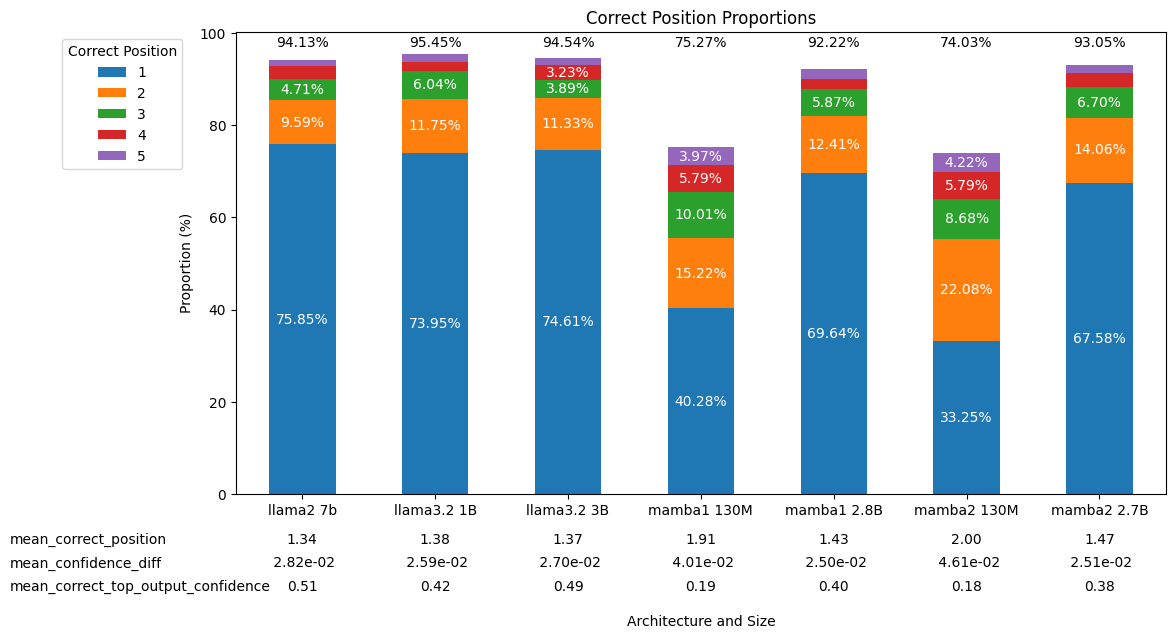

In [208]:
def plot_correct_position_proportions(
    df,
    additional_info_cols=[
        "mean_correct_position",
        "mean_confidence_diff",
        "mean_correct_top_output_confidence",
    ],
):
    rename_col = lambda col: col.replace("correct_position_", "")
    correct_position_cols = [
        col for col in df.columns if col.startswith("correct_position_")
    ]

    correct_position_df = df.assign(
        **{
            rename_col(col): df[col].apply(lambda x: float(x.rstrip("%")))
            for col in correct_position_cols
        }
    ).melt(
        id_vars=["arch_name", "size"],
        value_vars=map(rename_col, correct_position_cols),
        var_name="correct_position",
        value_name="proportion",
    )

    correct_position_df["arch_size"] = (
        correct_position_df["arch_name"] + " " + correct_position_df["size"]
    )

    # Pivot the data to make it suitable for a stacked bar plot
    pivot_df = correct_position_df.pivot_table(
        index=["arch_size"], columns="correct_position", values="proportion"
    )

    # Plotting the stacked bar plot
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Correct Position Proportions")

    plt.xlabel("Architecture and Size", labelpad=10 + 20 * len(additional_info_cols))
    plt.ylabel("Proportion (%)")
    plt.xticks(rotation=0)
    plt.legend(title="Correct Position", bbox_to_anchor=(-0.05, 1), loc="upper right")

    n_bars = len(pivot_df)
    height = {i: 0 for i in range(n_bars)}
    # Adding total amount on top of each bar
    for idx, bar in enumerate(ax.patches):
        bar_i = idx % n_bars
        position_i = idx // n_bars
        if bar.get_height() > 3:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height[bar_i] + bar.get_height() / 2,
                f"{pivot_df.iloc[bar_i, position_i]:.2f}%",
                fontsize=10,
                ha="center",
                va="center",
                color="white",
            )

        height[bar_i] += bar.get_height()

    for i, col in enumerate(additional_info_cols):
        ax.text(
            -2.2,
            -10 - i * 5,
            col,
            fontsize=10,
            ha="left",
            va="center",
            color="black",
        )

    # Adding summary on each model
    for i in range(n_bars):
        bar_location = ax.patches[i].get_x() + ax.patches[i].get_width() / 2
        model_stats = df.iloc[i]

        ax.text(
            bar_location,
            98,
            model_stats["accuracy_any_correct"],
            fontsize=10,
            ha="center",
            va="center",
            color="black",
        )

        for j, col in enumerate(additional_info_cols):
            ax.text(
                bar_location,
                -10 - j * 5,
                model_stats[col],
                fontsize=10,
                ha="center",
                va="center",
                color="black",
            )

    # plt.tight_layout()
    plt.show()


plot_correct_position_proportions(per_model_stats_df)

## Combining Data
#

In [210]:
# Predefined constants for column names
INDEX_COL = "known_id"
TOTAL_CORRECT_COL = "total_correct"
AGGREEMENT_TYPE_COL = "agreement_type"
MODEL_CORRECT_COL = "model_correct"
INDEX_COLUMNS = ["arch_name", "size"]
PER_MODEL_COLS = [
    MODEL_CORRECT_COL,
    "model_output",
    "model_top_output_confidence",
    "model_generation",
    "model_top_outputs",
    'correct_position',
    'confidence_diff',
    'any_correct',
]
SHARE_COLS = [col for col in df.columns if col not in PER_MODEL_COLS + [INDEX_COL]]

# Processing the data using pipes
result = (
    pd.concat(
        [
            df.assign(arch_name=name[0], size=name[1])
            for name, df in known_1000_correct_files.items()
        ]
    )
    .set_index(INDEX_COL)
    .pipe(
        lambda df: (
            pd.concat(
                [
                    df[PER_MODEL_COLS + INDEX_COLUMNS]
                    .set_index(INDEX_COLUMNS, append=True)
                    .unstack(level=[-2, -1]),
                    df[SHARE_COLS].drop_duplicates().sort_index(),
                ],
                axis=1,
            )
        )
    )
    .pipe(
        lambda df: df.assign(
            **{
                TOTAL_CORRECT_COL: df[
                    [col for col in df.columns if col[0] == MODEL_CORRECT_COL]
                ].sum(axis=1),
                'total_any_correct': df[
                    [col for col in df.columns if col[0] == 'any_correct']
                ].sum(axis=1),
                AGGREEMENT_TYPE_COL: (
                    df[[col for col in df.columns if col[0] == MODEL_CORRECT_COL]]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
                'any_correct_agreement_type': (
                    df[[col for col in df.columns if col[0] == 'any_correct']]
                    .astype(int)
                    .apply(lambda x: "".join(x.astype(str)), axis=1)
                ),
            }
        )
    )
)

# Experiments

## Experiment 1 - Value Counts

### Experiment 1.1 - Value Counts for Total Correct

In [222]:
result

,"(model_correct, llama2, 7b)","(model_correct, llama3.2, 1B)","(model_correct, llama3.2, 3B)","(model_correct, mamba1, 130M)","(model_correct, mamba1, 2.8B)","(model_correct, mamba2, 130M)","(model_correct, mamba2, 2.7B)","(model_output, llama2, 7b)","(model_output, llama3.2, 1B)","(model_output, llama3.2, 3B)","(model_output, mamba1, 130M)","(model_output, mamba1, 2.8B)","(model_output, mamba2, 130M)","(model_output, mamba2, 2.7B)","(model_top_output_confidence, llama2, 7b)","(model_top_output_confidence, llama3.2, 1B)","(model_top_output_confidence, llama3.2, 3B)","(model_top_output_confidence, mamba1, 130M)","(model_top_output_confidence, mamba1, 2.8B)","(model_top_output_confidence, mamba2, 130M)","(model_top_output_confidence, mamba2, 2.7B)","(model_generation, llama2, 7b)","(model_generation, llama3.2, 1B)","(model_generation, llama3.2, 3B)","(model_generation, mamba1, 130M)","(model_generation, mamba1, 2.8B)","(model_generation, mamba2, 130M)","(model_generation, mamba2, 2.7B)","(model_top_outputs, llama2, 7b)","(model_top_outputs, llama3.2, 1B)","(model_top_outputs, llama3.2, 3B)","(model_top_outputs, mamba1, 130M)","(model_top_outputs, mamba1, 2.8B)","(model_top_outputs, mamba2, 130M)","(model_top_outputs, mamba2, 2.7B)","(correct_position, llama2, 7b)","(correct_position, llama3.2, 1B)","(correct_position, llama3.2, 3B)","(correct_position, mamba1, 130M)","(correct_position, mamba1, 2.8B)","(correct_position, mamba2, 130M)","(correct_position, mamba2, 2.7B)","(confidence_diff, llama2, 7b)","(confidence_diff, llama3.2, 1B)","(confidence_diff, llama3.2, 3B)","(confidence_diff, mamba1, 130M)","(confidence_diff, mamba1, 2.8B)","(confidence_diff, mamba2, 130M)","(confidence_diff, mamba2, 2.7B)","(any_correct, llama2, 7b)","(any_correct, llama3.2, 1B)","(any_correct, llama3.2, 3B)","(any_correct, mamba1, 130M)","(any_correct, mamba1, 2.8B)","(any_correct, mamba2, 130M)","(any_correct, mamba2, 2.7B)",subject,attribute,template,prediction,prompt,relation_id,total_correct,total_any_correct,agreement_type,any_correct_agreement_type
known_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,True,False,True,False,True,True,True,Ant,North,Antarctica,Africa,Antar,Antar,Antar,0.973737,0.175083,0.959903,0.164639,0.958787,0.248480,0.555260,Antarctica. It,North America. It is,Antarctica. It is the,Africa. It is located,Antarctica. It is,Antarctica. It is,Antarctica. It is,"[[Ant, 0.9737366437911987], [Asia, 0.0068824938498437405], [AN, 0.004217145964503288], [Africa, ...","[[ North, 0.1750827133655548], [ Africa, 0.14921218156814575], [ Europe, 0.13322310149669647], [...","[[ Antarctica, 0.959902822971344], [ Ant, 0.011826896108686924], [ the, 0.005402852781116962], [...","[[ Africa, 0.1646391898393631], [ South, 0.10606048256158829], [ Antar, 0.059981293976306915], [...","[[ Antar, 0.9587869048118591], [ East, 0.009866339154541492], [ Africa, 0.006568876560777426], [...","[[ Antar, 0.2484801709651947], [ South, 0.05927937477827072], [ Africa, 0.04430869221687317], [ ...","[[ Antar, 0.5552597641944885], [ Africa, 0.1617254763841629], [ V, 0.02987685799598694], [ Ant, ...",1.0,4.0,1.0,3.0,1.0,1.0,1.0,0.00000,0.061722,0.000000,0.104658,0.000000,0.000000,0.000000,True,True,True,True,True,True,True,Vinson Massif,Antarctica,{} is located in the continent,of Antarctica. It is the largest of the three,Vinson Massif is located in the continent of,P30,5,7,1010111,1111111
1,True,True,True,False,True,False,True,Apple,Apple,Apple,Be,Apple,the,Apple,0.719771,0.523722,0.827143,0.137130,0.400941,0.094976,0.629409,"Apple, but it’","Apple, and it’s","Apple, but it’s","Beats Music, Inc","Apple, which also owns",the Beats Music Group,"Apple, and it's","[[Apple, 0.7197712063789368], [the, 0.07393194735050201], [Be, 0.01898208074271679], [a, 0.01516...","[[ Apple, 0.5237215757369995], [ Beats, 0.3173734247684479], [ the, 0.02976669929921627], [ Jimm...","[[ Apple, 0.8271434903144836], [ Dr, 0.036285318434238434], [ the, 0.03598419949412

In [211]:
# Print value counts for total_correct
(
    result[TOTAL_CORRECT_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)


total_correct
5    24.98%
6    18.20%
7    14.81%
4    12.32%
3     9.02%
2     7.11%
0     6.78%
1     6.78%
Name: proportion, dtype: object

In [221]:
# Print value counts for total_correct
(
    result['total_any_correct']
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)


total_any_correct
7    59.72%
6    16.96%
5    14.72%
4     3.72%
3     2.23%
2     1.32%
1     1.08%
0     0.25%
Name: proportion, dtype: object

### Experiment 1.2 - Agreement Type Value Counts
#
In this experiment, we will look at the value counts of the agreement types.
Agreement type is a string that encodes which models agreed on a correct prediction.
#

In [213]:
# Print value counts for agreement_type
agreement_type_counts = (
    result[AGGREEMENT_TYPE_COL]
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)

# Filter and calculate cumulative counts
threshold = 0.5
filtered_agreement_type_counts = (
    agreement_type_counts
    .str.strip("%").astype(float)
    .pipe(lambda s: s[s > threshold])  # 1.0 corresponds to 1%
    .pipe(lambda s: pd.DataFrame({
        'agreement_type_counts': s,
        'cumulative_counts': s.cumsum()
    }))
    .map(lambda x: f"{x:.2f}%")
).T

filtered_agreement_type_counts


agreement_type,1110101,1111111,1111101,0000000,1110111,1110000,1110100,1110001,1111110,1000000,1010101,0000001,1100101,1111100,1011111,0000010,0001000,1010000,1111011,0000100,1111001,0110000,0110101,1010100,0000101,0100000,1100000,1011101,0010000,0100001,0100100,1111010,0010101,1110110
agreement_type_counts,18.44%,14.81%,8.93%,6.78%,4.55%,2.73%,2.56%,2.48%,1.82%,1.41%,1.32%,1.24%,1.16%,1.08%,0.99%,0.99%,0.91%,0.91%,0.91%,0.83%,0.83%,0.74%,0.74%,0.74%,0.74%,0.74%,0.66%,0.66%,0.66%,0.66%,0.66%,0.66%,0.58%,0.58%
cumulative_counts,18.44%,33.25%,42.18%,48.96%,53.51%,56.24%,58.80%,61.28%,63.10%,64.51%,65.83%,67.07%,68.23%,69.31%,70.30%,71.29%,72.20%,73.11%,74.02%,74.85%,75.68%,76.42%,77.16%,77.90%,78.64%,79.38%,80.04%,80.70%,81.36%,82.02%,82.68%,83.34%,83.92%,84.50%


In [214]:
# Print value counts for agreement_type
agreement_type_counts = (
    result['any_correct_agreement_type']
    .value_counts(normalize=True)
    .map(lambda x: f"{x:.2%}")
)

# Filter and calculate cumulative counts
threshold = 0.5
filtered_agreement_type_counts = (
    agreement_type_counts
    .str.strip("%").astype(float)
    .pipe(lambda s: s[s > threshold])  # 1.0 corresponds to 1%
    .pipe(lambda s: pd.DataFrame({
        'agreement_type_counts': s,
        'cumulative_counts': s.cumsum()
    }))
    .map(lambda x: f"{x:.2f}%")
).T

filtered_agreement_type_counts


any_correct_agreement_type,1111111,1110101,1111101,1110111,1111110,1110001,0111111,1111011,1110000
agreement_type_counts,59.72%,11.25%,7.44%,5.71%,1.41%,1.16%,0.91%,0.83%,0.74%
cumulative_counts,59.72%,70.97%,78.41%,84.12%,85.53%,86.69%,87.60%,88.43%,89.17%


### Examples of Agreement Type Mistakes
#

In [215]:
agreement_type_example = '1110101'
i_example = 3

example = result[result[AGGREEMENT_TYPE_COL] == agreement_type_example].iloc[[i_example]]

indexed_columns = [
    col for col in example.columns
    if isinstance(col, tuple)
]

# Print shared_columns
display(example.drop(columns=indexed_columns))

print('-'*50)

(
    example[indexed_columns]
    .melt(var_name='variable', value_name='value')
    .assign(col=lambda df_: df_['variable'].apply(lambda x: x[0]), 
            arch_name=lambda df_: df_['variable'].apply(lambda x: x[1]),
            size=lambda df_: df_['variable'].apply(lambda x: x[2]))
    .drop(columns=['variable'])
    .pivot(index=INDEX_COLUMNS, columns='col', values='value')
    .drop(columns=['model_output', 'model_top_output_confidence'])
    .pipe(split_top_outputs)
)


,subject,attribute,template,prediction,prompt,relation_id,total_correct,total_any_correct,agreement_type,any_correct_agreement_type
known_id,,,,,,,,,,
14,Eavan Boland,Dublin,{} was born in,"Dublin, Ireland, in 1971. He is the",Eavan Boland was born in,P19,5,5,1110101,1110101


--------------------------------------------------


col            any_correct confidence_diff correct_position model_correct  \
arch_name size                                                              
llama2    7b          True             0.0              1.0          True   
llama3.2  1B          True             0.0              1.0          True   
          3B          True             0.0              1.0          True   
mamba1    130M       False             inf              inf         False   
          2.8B        True             0.0              1.0          True   
mamba2    130M       False             inf              inf         False   
          2.7B        True             0.0              1.0          True   

col                      model_generation   pred_1  confidence_1 pred_2  \
arch_name size                                                            
llama2    7b                 Dublin in 19   Dublin      0.807877          
llama3.2  1B               Dublin in 1939   Dublin      0.341394          
          3B               Dublin in 1944   Dublin      0.577861          
mamba1    130M    the United States in 18      the      0.048318     18   
          2.8B        Dublin in 1958. She   Dublin      0.277287   Cork   
mamba2    130M   the United States in the      the      0.033199    New   
          2.7B        Dublin in 1945. She   Dublin      0.393851   Cork   

col             confidence_2    pred_3  confidence_3    pred_4  confidence_4  \
arch_name size                                                                 
llama2    7b        0.078686         L      0.030683    London      0.023324   
llama3.2  1B        0.197181    County      0.042620   Ireland      0.039952   
          3B        0.097179   Ireland      0.083297      Cork      0.052137   
mamba1    130M      0.030096       New      0.017279    London      0.011151   
          2.8B      0.068107   Belfast      0.063269   Ireland      0.039757   
mamba2    130M      0.025171        St      0.012934         a      0.011154   
          2.7B      0.070626    County      0.042951   Belfast      0.030245   

col                pred_5  confidence_5  
arch_name size                           
llama2    7b       County      0.018210  
llama3.2  1B         Cork      0.035656  
          3B            L      0.020930  
mamba1    130M    Ireland      0.010442  
          2.8B     County      0.028276  
mamba2    130M   Brooklyn      0.010202  
          2.7B    Ireland      0.029852

## Experiment 2 - Relation ID Interactions
#
### Value Counts for Relation ID
#

In [216]:
# Value counts for relation_id
result['relation_id'].value_counts().tail(10)


relation_id
P131     28
P413     28
P740     26
P1303    26
P136     25
P463     20
P1412    19
P106     16
P138      9
P190      1
Name: count, dtype: int64

### Aggregated Statistics for Relation ID
#

In [217]:
# Aggregated statistics for relation_id
# Only keep relation_ids that appear at least 25 times, then get top 100 per id
top_relation_ids = (
    result
    .pipe(lambda df: df[df['relation_id'].map(df['relation_id'].value_counts()) >= 25])
    .groupby('relation_id')[AGGREEMENT_TYPE_COL]
    .value_counts(normalize=True)
    .groupby(level=0)
    .head(100)
    .unstack(level=0)
)

# Display aggregated statistics
top_relation_ids


relation_id,P101,P103,P108,P127,P1303,P131,P136,P140,P159,P17,P176,P178,P19,P20,P27,P276,P30,P36,P364,P37,P39,P407,P413,P449,P495,P641,P740,P937
agreement_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000000,0.133333,NaN,0.020408,0.046512,0.076923,0.250000,0.20,NaN,0.021277,0.021739,0.108696,0.083333,0.069767,NaN,0.042553,0.088235,NaN,NaN,0.029412,0.043478,0.256410,0.022222,0.107143,0.06,NaN,0.052632,0.115385,0.075
0000001,NaN,NaN,NaN,NaN,NaN,0.035714,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041667,NaN,NaN,NaN,0.025641,0.022222,NaN,0.02,NaN,0.078947,NaN,0.050
0000010,NaN,NaN,0.020408,NaN,NaN,0.035714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020833,0.020408,NaN,0.021739,0.025641,0.044444,NaN,NaN,NaN,NaN,NaN,NaN
0000011,0.022222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000100,0.044444,NaN,NaN,NaN,0.038462,0.071429,0.04,NaN,NaN,NaN,0.021739,NaN,NaN,NaN,NaN,NaN,0.020833,NaN,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,0.038462,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021739,0.020833,0.046512,0.020408,NaN,NaN,NaN,0.040816,0.029412,NaN,0.025641,NaN,NaN,NaN,NaN,NaN,NaN,0.050
1111100,0.022222,0.021277,NaN,0.023256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.046512,NaN,0.063830,0.029412,NaN,NaN,0.088235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.038462,NaN
1111101,0.022222,0.063830,0.040816,0.139535,0.115385,0.035714,NaN,0.243902,0.063830,0.152174,0.065217,0.166667,0.116279,0.020408,0.148936,0.058824,0.187500,0.081633,0.205882,0.173913,0.051282,0.066667,0.107143,0.02,NaN,0.105263,0.076923,0.025


### Visualizing - Heatmap of Relation IDs
#

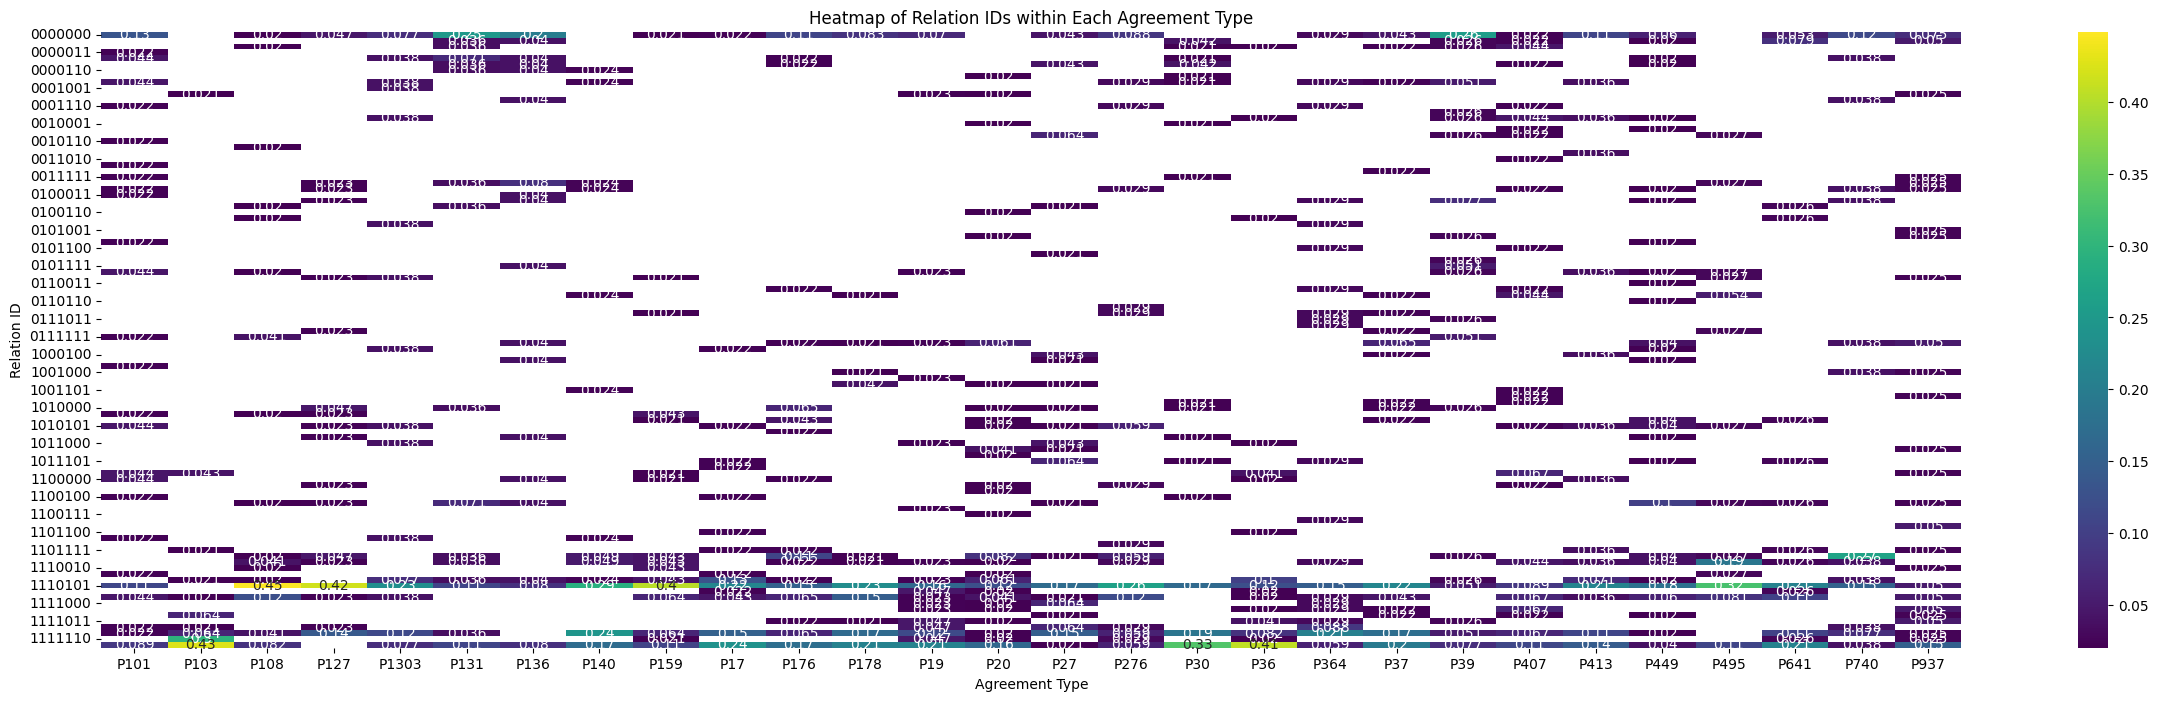

In [218]:
# Create a heatmap for the relation_ids DataFrame
plt.figure(figsize=(30, 8))
sns.heatmap(top_relation_ids, annot=True, cmap='viridis', cbar=True)
plt.title('Heatmap of Relation IDs within Each Agreement Type')
plt.xlabel('Agreement Type')
plt.ylabel('Relation ID')
plt.show()
